In [1]:
import serial
import threading
import time
from collections import deque
import tkinter as tk
import queue
import atexit

In [2]:
# Requires: pip install pyserial
# Run in Jupyter (close any Serial Monitor first so COM port is free)



# ---------- USER CONFIG ----------
PORT = "COM9"         # change to your port if needed
BAUD = 9600         # change to match Serial.begin(...) on ESP
THRESHOLD = 80.0     # dead-zone threshold (absolute). Adjust to your needs
SMOOTH_WINDOW = 8     # moving average window (samples)
MAX_SIGNAL = 500.0   # value mapped to full brightness (10). adjust to your signal range
USE_SMOOTH = !False   # whether the bulb uses smoothed value or raw value to decide
# ---------------------------------

# safe queue to pass values from serial thread to GUI/main thread
val_queue = queue.Queue()
stop_event = threading.Event()

def open_serial(port, baud):
    try:
        ser = serial.Serial(port, baud, timeout=1)
        # allow ESP to reboot after opening the port
        time.sleep(2.0)
        print("Connected to", ser.name)
        return ser
    except Exception as e:
        print("Could not open serial port:", e)
        return None

def serial_reader(ser, q, stop_ev):
    """
    Read lines from serial and push floats into queue.
    """
    while not stop_ev.is_set():
        try:
            line = ser.readline().decode('utf-8', errors='ignore').strip()
            if not line:
                continue
            # try parsing float
            try:
                val = float(line)
            except ValueError:
                # ignore non-numeric lines
                continue
            q.put(val)
        except Exception as e:
            # keep running; print once every so often might help debugging
            print("Serial read error:", e)
            time.sleep(0.1)

# ---------- Tkinter bulb control ----------
class BulbApp:
    def _init_(self, root):
        self.root = root
        root.title("ESP8266 BCI Bulb (Thresholded)")
        self.canvas = tk.Canvas(root, width=320, height=420, bg="black")
        self.canvas.pack()
        # bulb circle
        self.bulb = self.canvas.create_oval(60, 30, 260, 230, fill="black", outline="white", width=2)
        # glowing halo (we will change its alpha-ish by color intensity)
        self.halo = self.canvas.create_oval(40, 10, 280, 250, fill="", outline="")
        # base
        self.canvas.create_rectangle(130, 200, 190, 290, fill="gray", outline="white")
        # status text
        self.raw_text = self.canvas.create_text(160, 310, text="Raw: --", fill="white", font=("Arial", 12))
        self.smooth_text = self.canvas.create_text(160, 335, text="Smooth: --", fill="white", font=("Arial", 12))
        self.mode_text = self.canvas.create_text(160, 360, text=f"Mode: {'SMOOTH' if USE_SMOOTH else 'RAW'}  TH={THRESHOLD}", fill="white", font=("Arial", 11))
        self.brightness_level = 0  # 0..10

    def set_brightness(self, level:int):
        """
        level: 0..10
        change bulb fill color according to brightness
        """
        level = max(0, min(10, int(level)))
        self.brightness_level = level
        # compute color intensity; small level -> dim yellow; high level -> bright yellow
        # map 0..10 -> 0..255
        intensity = int((level / 10.0) * 255)
        # clamp
        intensity = max(0, min(255, intensity))
        # create a warm yellow color: (R,G,B) = (intensity, intensity, 20) -> hex
        color_hex = f"#{intensity:02x}{intensity:02x}{20:02x}"
        # create a halo color (lighter, but not too bright)
        halo_int = min(255, int(intensity * 1.0))
        halo_hex = f"#{halo_int:02x}{halo_int:02x}{10:02x}"
        # if level 0 -> turn off (black)
        if level == 0:
            self.canvas.itemconfig(self.bulb, fill="black")
            self.canvas.itemconfig(self.halo, fill="")
        else:
            self.canvas.itemconfig(self.bulb, fill=color_hex)
            self.canvas.itemconfig(self.halo, fill=halo_hex)

    def update_texts(self, raw, smooth):
        self.canvas.itemconfig(self.raw_text, text=f"Raw: {raw:.2f}")
        self.canvas.itemconfig(self.smooth_text, text=f"Smooth: {smooth:.2f}")

# ---------- helper functions ----------
def compute_moving_average(window_deque, new_val):
    window_deque.append(new_val)
    return sum(window_deque) / len(window_deque)

def map_to_brightness(value_abs, threshold, max_signal):
    """
    Map absolute value (after thresholding) to 0..10 brightness.
    value_abs: absolute signal
    threshold: threshold below which it's considered off
    max_signal: value that maps to brightness 10
    """
    if value_abs <= threshold:
        return 0
    # linear mapping
    denom = (max_signal - threshold) if (max_signal - threshold) != 0 else 1.0
    normalized = (value_abs - threshold) / denom
    level = int(normalized * 10.0)
    if level < 0:
        level = 0
    if level > 10:
        level = 10
    return level

# ---------- main logic tying serial -> filter -> bulb ----------
def run_app():
    ser = open_serial(PORT, BAUD)
    if ser is None:
        print("Serial open failed. Make sure port and baud are correct and the port is free.")
        return

    # start reader thread
    t = threading.Thread(target=serial_reader, args=(ser, val_queue, stop_event), daemon=True)
    t.start()

    root = tk.Tk()
    app = BulbApp(root)

    # deque for smoothing
    window = deque(maxlen=SMOOTH_WINDOW)
    last_print_time = 0.0

    def poll_queue_and_update():
        nonlocal last_print_time
        updated = False
        raw_val = None
        smooth_val = None

        # consume all queued values, but keep last (for smoothing)
        while not val_queue.empty():
            try:
                raw_val = val_queue.get_nowait()
            except queue.Empty:
                break
            # update moving average
            smooth_val = compute_moving_average(window, raw_val)
            updated = True

        # if we got at least one new value, process it
        if updated and raw_val is not None and smooth_val is not None:
            # Decide whether to use smoothed value or raw to trigger bulb
            used_value = smooth_val if USE_SMOOTH else raw_val
            used_abs = abs(used_value)

            # get brightness
            level = map_to_brightness(used_abs, THRESHOLD, MAX_SIGNAL)
            app.set_brightness(level)

            # print to console occasionally for debugging / logging; do not flood
            now = time.time()
            if now - last_print_time > 0.05:  # print at most 20 Hz
                # print both raw and smoothed and brightness
                print(f"Signal raw: {raw_val:.2f}  smooth: {smooth_val:.2f}  -> abs: {used_abs:.2f}  brightness: {level}")
                last_print_time = now

            # update GUI text
            app.update_texts(raw_val, smooth_val)

        # schedule next poll
        root.after(20, poll_queue_and_update)  # poll every 20 ms

    # start polling loop
    root.after(20, poll_queue_and_update)

    # clean close on exit
    def on_close():
        stop_event.set()
        try:
            if ser and ser.is_open:
                ser.close()
        except Exception:
            pass
        root.destroy()

    root.protocol("WM_DELETE_WINDOW", on_close)
    atexit.register(on_close)

    root.mainloop()

# ---------- run ----------
# if _name_ == "_main_":
# run_app()# Requires: pip install pyserial
# Run in Jupyter (close any Serial Monitor first so COM port is free)



# ---------- USER CONFIG ----------
PORT = "COM9"         # change to your port if needed
BAUD = 9600         # change to match Serial.begin(...) on ESP
THRESHOLD = 80.0     # dead-zone threshold (absolute). Adjust to your needs
SMOOTH_WINDOW = 8     # moving average window (samples)
MAX_SIGNAL = 500.0   # value mapped to full brightness (10). adjust to your signal range
USE_SMOOTH = !False   # whether the bulb uses smoothed value or raw value to decide
# ---------------------------------

# safe queue to pass values from serial thread to GUI/main thread
val_queue = queue.Queue()
stop_event = threading.Event()

def open_serial(port, baud):
    try:
        ser = serial.Serial(port, baud, timeout=1)
        # allow ESP to reboot after opening the port
        time.sleep(2.0)
        print("Connected to", ser.name)
        return ser
    except Exception as e:
        print("Could not open serial port:", e)
        return None

def serial_reader(ser, q, stop_ev):
    """
    Read lines from serial and push floats into queue.
    """
    while not stop_ev.is_set():
        try:
            line = ser.readline().decode('utf-8', errors='ignore').strip()
            if not line:
                continue
            # try parsing float
            try:
                val = float(line)
            except ValueError:
                # ignore non-numeric lines
                continue
            q.put(val)
        except Exception as e:
            # keep running; print once every so often might help debugging
            print("Serial read error:", e)
            time.sleep(0.1)

# ---------- Tkinter bulb control ----------
class BulbApp:
    def _init_(self, root):
        self.root = root
        root.title("ESP8266 BCI Bulb (Thresholded)")
        self.canvas = tk.Canvas(root, width=320, height=420, bg="black")
        self.canvas.pack()
        # bulb circle
        self.bulb = self.canvas.create_oval(60, 30, 260, 230, fill="black", outline="white", width=2)
        # glowing halo (we will change its alpha-ish by color intensity)
        self.halo = self.canvas.create_oval(40, 10, 280, 250, fill="", outline="")
        # base
        self.canvas.create_rectangle(130, 200, 190, 290, fill="gray", outline="white")
        # status text
        self.raw_text = self.canvas.create_text(160, 310, text="Raw: --", fill="white", font=("Arial", 12))
        self.smooth_text = self.canvas.create_text(160, 335, text="Smooth: --", fill="white", font=("Arial", 12))
        self.mode_text = self.canvas.create_text(160, 360, text=f"Mode: {'SMOOTH' if USE_SMOOTH else 'RAW'}  TH={THRESHOLD}", fill="white", font=("Arial", 11))
        self.brightness_level = 0  # 0..10

    def set_brightness(self, level:int):
        """
        level: 0..10
        change bulb fill color according to brightness
        """
        level = max(0, min(10, int(level)))
        self.brightness_level = level
        # compute color intensity; small level -> dim yellow; high level -> bright yellow
        # map 0..10 -> 0..255
        intensity = int((level / 10.0) * 255)
        # clamp
        intensity = max(0, min(255, intensity))
        # create a warm yellow color: (R,G,B) = (intensity, intensity, 20) -> hex
        color_hex = f"#{intensity:02x}{intensity:02x}{20:02x}"
        # create a halo color (lighter, but not too bright)
        halo_int = min(255, int(intensity * 1.0))
        halo_hex = f"#{halo_int:02x}{halo_int:02x}{10:02x}"
        # if level 0 -> turn off (black)
        if level == 0:
            self.canvas.itemconfig(self.bulb, fill="black")
            self.canvas.itemconfig(self.halo, fill="")
        else:
            self.canvas.itemconfig(self.bulb, fill=color_hex)
            self.canvas.itemconfig(self.halo, fill=halo_hex)

    def update_texts(self, raw, smooth):
        self.canvas.itemconfig(self.raw_text, text=f"Raw: {raw:.2f}")
        self.canvas.itemconfig(self.smooth_text, text=f"Smooth: {smooth:.2f}")

# ---------- helper functions ----------
def compute_moving_average(window_deque, new_val):
    window_deque.append(new_val)
    return sum(window_deque) / len(window_deque)

def map_to_brightness(value_abs, threshold, max_signal):
    """
    Map absolute value (after thresholding) to 0..10 brightness.
    value_abs: absolute signal
    threshold: threshold below which it's considered off
    max_signal: value that maps to brightness 10
    """
    if value_abs <= threshold:
        return 0
    # linear mapping
    denom = (max_signal - threshold) if (max_signal - threshold) != 0 else 1.0
    normalized = (value_abs - threshold) / denom
    level = int(normalized * 10.0)
    if level < 0:
        level = 0
    if level > 10:
        level = 10
    return level

# ---------- main logic tying serial -> filter -> bulb ----------
def run_app():
    ser = open_serial(PORT, BAUD)
    if ser is None:
        print("Serial open failed. Make sure port and baud are correct and the port is free.")
        return

    # start reader thread
    t = threading.Thread(target=serial_reader, args=(ser, val_queue, stop_event), daemon=True)
    t.start()

    root = tk.Tk()
    app = BulbApp(root)

    # deque for smoothing
    window = deque(maxlen=SMOOTH_WINDOW)
    last_print_time = 0.0

    def poll_queue_and_update():
        nonlocal last_print_time
        updated = False
        raw_val = None
        smooth_val = None

        # consume all queued values, but keep last (for smoothing)
        while not val_queue.empty():
            try:
                raw_val = val_queue.get_nowait()
            except queue.Empty:
                break
            # update moving average
            smooth_val = compute_moving_average(window, raw_val)
            updated = True

        # if we got at least one new value, process it
        if updated and raw_val is not None and smooth_val is not None:
            # Decide whether to use smoothed value or raw to trigger bulb
            used_value = smooth_val if USE_SMOOTH else raw_val
            used_abs = abs(used_value)

            # get brightness
            level = map_to_brightness(used_abs, THRESHOLD, MAX_SIGNAL)
            app.set_brightness(level)

            # print to console occasionally for debugging / logging; do not flood
            now = time.time()
            if now - last_print_time > 0.05:  # print at most 20 Hz
                # print both raw and smoothed and brightness
                print(f"Signal raw: {raw_val:.2f}  smooth: {smooth_val:.2f}  -> abs: {used_abs:.2f}  brightness: {level}")
                last_print_time = now

            # update GUI text
            app.update_texts(raw_val, smooth_val)

        # schedule next poll
        root.after(20, poll_queue_and_update)  # poll every 20 ms

    # start polling loop
    root.after(20, poll_queue_and_update)

    # clean close on exit
    def on_close():
        stop_event.set()
        try:
            if ser and ser.is_open:
                ser.close()
        except Exception:
            pass
        root.destroy()

    root.protocol("WM_DELETE_WINDOW", on_close)
    atexit.register(on_close)

    root.mainloop()

# ---------- run ----------
# if _name_ == "_main_":
run_app()

Could not open serial port: could not open port 'COM9': PermissionError(13, 'Access is denied.', None, 5)
Serial open failed. Make sure port and baud are correct and the port is free.


In [3]:
# Requires: pip install pyserial
# Run in Jupyter (close any Serial Monitor first so COM port is free)



# ---------- USER CONFIG ----------
PORT = "COM9"         # change to your port if needed
BAUD = 9600         # change to match Serial.begin(...) on ESP
THRESHOLD = 80.0     # dead-zone threshold (absolute). Adjust to your needs
SMOOTH_WINDOW = 8     # moving average window (samples)
MAX_SIGNAL = 500.0   # value mapped to full brightness (10). adjust to your signal range
USE_SMOOTH = !False   # whether the bulb uses smoothed value or raw value to decide
# ---------------------------------

# safe queue to pass values from serial thread to GUI/main thread
val_queue = queue.Queue()
stop_event = threading.Event()

def open_serial(port, baud):
    try:
        ser = serial.Serial(port, baud, timeout=1)
        # allow ESP to reboot after opening the port
        time.sleep(2.0)
        print("Connected to", ser.name)
        return ser
    except Exception as e:
        print("Could not open serial port:", e)
        return None

def serial_reader(ser, q, stop_ev):
    """
    Read lines from serial and push floats into queue.
    """
    while not stop_ev.is_set():
        try:
            line = ser.readline().decode('utf-8', errors='ignore').strip()
            if not line:
                continue
            # try parsing float
            try:
                val = float(line)
            except ValueError:
                # ignore non-numeric lines
                continue
            q.put(val)
        except Exception as e:
            # keep running; print once every so often might help debugging
            print("Serial read error:", e)
            time.sleep(0.1)

# ---------- Tkinter bulb control ----------
class BulbApp:
    def _init_(self, root):
        self.root = root
        root.title("ESP8266 BCI Bulb (Thresholded)")
        self.canvas = tk.Canvas(root, width=320, height=420, bg="black")
        self.canvas.pack()
        # bulb circle
        self.bulb = self.canvas.create_oval(60, 30, 260, 230, fill="black", outline="white", width=2)
        # glowing halo (we will change its alpha-ish by color intensity)
        self.halo = self.canvas.create_oval(40, 10, 280, 250, fill="", outline="")
        # base
        self.canvas.create_rectangle(130, 200, 190, 290, fill="gray", outline="white")
        # status text
        self.raw_text = self.canvas.create_text(160, 310, text="Raw: --", fill="white", font=("Arial", 12))
        self.smooth_text = self.canvas.create_text(160, 335, text="Smooth: --", fill="white", font=("Arial", 12))
        self.mode_text = self.canvas.create_text(160, 360, text=f"Mode: {'SMOOTH' if USE_SMOOTH else 'RAW'}  TH={THRESHOLD}", fill="white", font=("Arial", 11))
        self.brightness_level = 0  # 0..10

    def set_brightness(self, level:int):
        """
        level: 0..10
        change bulb fill color according to brightness
        """
        level = max(0, min(10, int(level)))
        self.brightness_level = level
        # compute color intensity; small level -> dim yellow; high level -> bright yellow
        # map 0..10 -> 0..255
        intensity = int((level / 10.0) * 255)
        # clamp
        intensity = max(0, min(255, intensity))
        # create a warm yellow color: (R,G,B) = (intensity, intensity, 20) -> hex
        color_hex = f"#{intensity:02x}{intensity:02x}{20:02x}"
        # create a halo color (lighter, but not too bright)
        halo_int = min(255, int(intensity * 1.0))
        halo_hex = f"#{halo_int:02x}{halo_int:02x}{10:02x}"
        # if level 0 -> turn off (black)
        if level == 0:
            self.canvas.itemconfig(self.bulb, fill="black")
            self.canvas.itemconfig(self.halo, fill="")
        else:
            self.canvas.itemconfig(self.bulb, fill=color_hex)
            self.canvas.itemconfig(self.halo, fill=halo_hex)

    def update_texts(self, raw, smooth):
        self.canvas.itemconfig(self.raw_text, text=f"Raw: {raw:.2f}")
        self.canvas.itemconfig(self.smooth_text, text=f"Smooth: {smooth:.2f}")

# ---------- helper functions ----------
def compute_moving_average(window_deque, new_val):
    window_deque.append(new_val)
    return sum(window_deque) / len(window_deque)

def map_to_brightness(value_abs, threshold, max_signal):
    """
    Map absolute value (after thresholding) to 0..10 brightness.
    value_abs: absolute signal
    threshold: threshold below which it's considered off
    max_signal: value that maps to brightness 10
    """
    if value_abs <= threshold:
        return 0
    # linear mapping
    denom = (max_signal - threshold) if (max_signal - threshold) != 0 else 1.0
    normalized = (value_abs - threshold) / denom
    level = int(normalized * 10.0)
    if level < 0:
        level = 0
    if level > 10:
        level = 10
    return level

# ---------- main logic tying serial -> filter -> bulb ----------
def run_app():
    ser = open_serial(PORT, BAUD)
    if ser is None:
        print("Serial open failed. Make sure port and baud are correct and the port is free.")
        return

    # start reader thread
    t = threading.Thread(target=serial_reader, args=(ser, val_queue, stop_event), daemon=True)
    t.start()

    root = tk.Tk()
    app = BulbApp(root)

    # deque for smoothing
    window = deque(maxlen=SMOOTH_WINDOW)
    last_print_time = 0.0

    def poll_queue_and_update():
        nonlocal last_print_time
        updated = False
        raw_val = None
        smooth_val = None

        # consume all queued values, but keep last (for smoothing)
        while not val_queue.empty():
            try:
                raw_val = val_queue.get_nowait()
            except queue.Empty:
                break
            # update moving average
            smooth_val = compute_moving_average(window, raw_val)
            updated = True

        # if we got at least one new value, process it
        if updated and raw_val is not None and smooth_val is not None:
            # Decide whether to use smoothed value or raw to trigger bulb
            used_value = smooth_val if USE_SMOOTH else raw_val
            used_abs = abs(used_value)

            # get brightness
            level = map_to_brightness(used_abs, THRESHOLD, MAX_SIGNAL)
            app.set_brightness(level)

            # print to console occasionally for debugging / logging; do not flood
            now = time.time()
            if now - last_print_time > 0.05:  # print at most 20 Hz
                # print both raw and smoothed and brightness
                print(f"Signal raw: {raw_val:.2f}  smooth: {smooth_val:.2f}  -> abs: {used_abs:.2f}  brightness: {level}")
                last_print_time = now

            # update GUI text
            app.update_texts(raw_val, smooth_val)

        # schedule next poll
        root.after(20, poll_queue_and_update)  # poll every 20 ms

    # start polling loop
    root.after(20, poll_queue_and_update)

    # clean close on exit
    def on_close():
        stop_event.set()
        try:
            if ser and ser.is_open:
                ser.close()
        except Exception:
            pass
        root.destroy()

    root.protocol("WM_DELETE_WINDOW", on_close)
    atexit.register(on_close)

    root.mainloop()

# ---------- run ----------
run_app()

Could not open serial port: could not open port 'COM9': PermissionError(13, 'Access is denied.', None, 5)
Serial open failed. Make sure port and baud are correct and the port is free.


EEG Brainwave Processing Server
This server will:
1. Receive filtered EEG data via WebSocket
2. Extract brainwave bands (Delta, Theta, Alpha, Beta, Gamma)
3. Display real-time analysis and plots
4. Send processed data back to clients

Starting server...
Server error: asyncio.run() cannot be called from a running event loop


C:\Users\nithi\AppData\Local\Temp\ipykernel_6208\1264905649.py:314: RuntimeWarning: coroutine 'EEGWebSocketServer.start_server' was never awaited
  print(f"Server error: {e}")


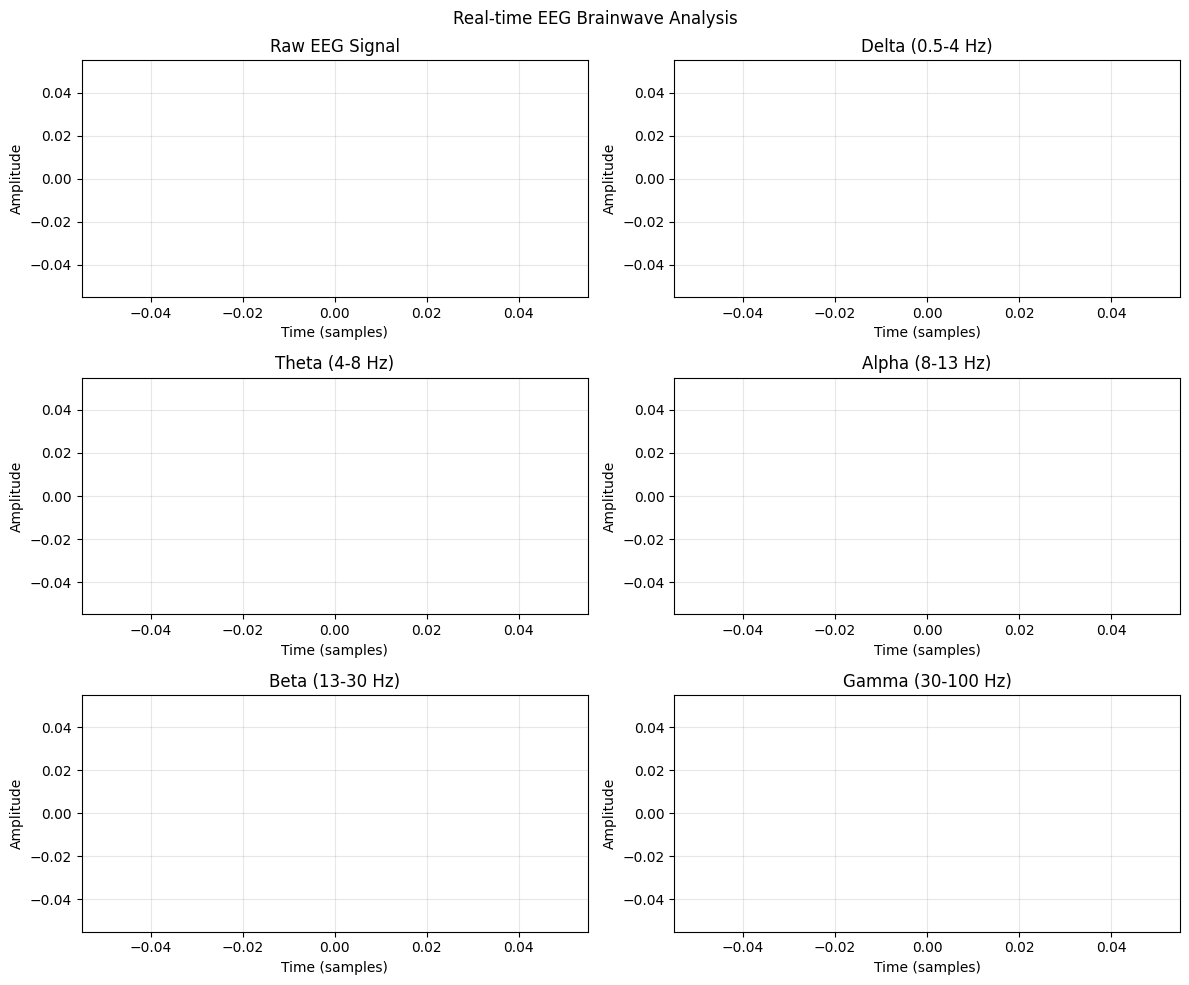

Actual sample rate: 0.00 Hz
Buffer size: 0
Actual sample rate: 0.00 Hz
Buffer size: 0
Actual sample rate: 0.00 Hz
Buffer size: 0
Actual sample rate: 0.00 Hz
Buffer size: 0
Actual sample rate: 0.00 Hz
Buffer size: 0
Actual sample rate: 0.00 Hz
Buffer size: 0
Actual sample rate: 0.00 Hz
Buffer size: 0
Actual sample rate: 0.00 Hz
Buffer size: 0
Actual sample rate: 0.00 Hz
Buffer size: 0
Actual sample rate: 0.00 Hz
Buffer size: 0
Actual sample rate: 0.00 Hz
Buffer size: 0
Actual sample rate: 0.00 Hz
Buffer size: 0
Actual sample rate: 0.00 Hz
Buffer size: 0
Actual sample rate: 0.00 Hz
Buffer size: 0
Actual sample rate: 0.00 Hz
Buffer size: 0
Actual sample rate: 0.00 Hz
Buffer size: 0
Actual sample rate: 0.00 Hz
Buffer size: 0
Actual sample rate: 0.00 Hz
Buffer size: 0
Actual sample rate: 0.00 Hz
Buffer size: 0
Actual sample rate: 0.00 Hz
Buffer size: 0
Actual sample rate: 0.00 Hz
Buffer size: 0
Actual sample rate: 0.00 Hz
Buffer size: 0
Actual sample rate: 0.00 Hz
Buffer size: 0
Actual samp

In [ ]:
import asyncio
import websockets
import json
import numpy as np
from scipy import signal
from collections import deque
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import threading
import time
from datetime import datetime

class EEGBandpassFilters:
    """
    EEG bandpass filters for extracting different brainwave frequencies
    """
    def __init__(self, sample_rate=250):
        self.sample_rate = sample_rate
        self.nyquist = sample_rate / 2
        
        # Design bandpass filters for each brainwave band
        self.filters = self._design_filters()
        
        # Initialize filter states for each band
        self.filter_states = {
            'delta': {'zi': None},
            'theta': {'zi': None}, 
            'alpha': {'zi': None},
            'beta': {'zi': None},
            'gamma': {'zi': None}
        }
    
    def _design_filters(self):
        """Design Butterworth bandpass filters for each brainwave band"""
        filters = {}
        
        # Brainwave frequency bands (Hz)
        bands = {
            'delta': (0.5, 4),     # Deep sleep, unconscious
            'theta': (4, 8),       # Drowsiness, meditation, creativity
            'alpha': (8, 13),      # Relaxed awareness, closed eyes
            'beta': (13, 30),      # Alert, focused, active thinking
            'gamma': (30, 100)     # High-level cognitive processing
        }
        
        for band_name, (low_freq, high_freq) in bands.items():
            # Normalize frequencies
            low = low_freq / self.nyquist
            high = high_freq / self.nyquist
            
            # Design 4th order Butterworth bandpass filter
            sos = signal.butter(4, [low, high], btype='band', output='sos')
            filters[band_name] = sos
            
        return filters
    
    def apply_bandpass_filters(self, data_sample):
        """Apply bandpass filters to extract brainwave bands"""
        results = {}
        
        for band_name, sos in self.filters.items():
            # Apply filter using sosfilt_zi for continuous filtering
            if self.filter_states[band_name]['zi'] is None:
                # Initialize filter state
                self.filter_states[band_name]['zi'] = signal.sosfilt_zi(sos)
            
            filtered_sample, zi = signal.sosfilt(sos, [data_sample], 
                                               zi=self.filter_states[band_name]['zi'])
            self.filter_states[band_name]['zi'] = zi
            
            results[band_name] = filtered_sample[0]
        
        return results

class EEGProcessor:
    """Main EEG processing class"""
    def __init__(self, buffer_size=1000, sample_rate=250):
        self.sample_rate = sample_rate
        self.buffer_size = buffer_size
        
        # Data buffers
        self.raw_buffer = deque(maxlen=buffer_size)
        self.filtered_buffer = deque(maxlen=buffer_size)
        self.brainwave_buffers = {
            'delta': deque(maxlen=buffer_size),
            'theta': deque(maxlen=buffer_size),
            'alpha': deque(maxlen=buffer_size),
            'beta': deque(maxlen=buffer_size),
            'gamma': deque(maxlen=buffer_size)
        }
        
        # Initialize bandpass filters
        self.bandpass_filters = EEGBandpassFilters(sample_rate)
        
        # Statistics tracking
        self.stats = {
            'samples_received': 0,
            'last_update': time.time(),
            'sample_rate_actual': 0
        }
        
        # Start statistics thread
        self.stats_thread = threading.Thread(target=self._update_stats, daemon=True)
        self.stats_thread.start()
        
        # Plotting setup
        self.setup_realtime_plot()
    
    def _update_stats(self):
        """Update statistics periodically"""
        while True:
            time.sleep(5)  # Update every 5 seconds
            current_time = time.time()
            time_diff = current_time - self.stats['last_update']
            if time_diff > 0:
                self.stats['sample_rate_actual'] = self.stats['samples_received'] / time_diff
                print(f"Actual sample rate: {self.stats['sample_rate_actual']:.2f} Hz")
                print(f"Buffer size: {len(self.filtered_buffer)}")
                self.print_brainwave_analysis()
                self.stats['samples_received'] = 0
                self.stats['last_update'] = current_time
    
    def process_sample(self, raw_value, filtered_value, timestamp):
        """Process a single EEG sample"""
        # Add to buffers
        self.raw_buffer.append(raw_value)
        self.filtered_buffer.append(filtered_value)
        
        # Extract brainwave bands
        brainwave_bands = self.bandpass_filters.apply_bandpass_filters(filtered_value)
        
        # Add brainwave data to buffers
        for band_name, value in brainwave_bands.items():
            self.brainwave_buffers[band_name].append(value)
        
        # Update statistics
        self.stats['samples_received'] += 1
        
        return brainwave_bands
    
    def print_brainwave_analysis(self):
        """Print analysis of brainwave activity"""
        if len(self.filtered_buffer) < 100:
            return
            
        print("\n" + "="*50)
        print("BRAINWAVE ANALYSIS")
        print("="*50)
        
        for band_name, buffer in self.brainwave_buffers.items():
            if len(buffer) > 50:
                # Calculate RMS power for each band
                recent_data = list(buffer)[-250:]  # Last 1 second of data
                rms_power = np.sqrt(np.mean(np.array(recent_data)**2))
                
                # Band descriptions
                descriptions = {
                    'delta': 'Deep sleep, unconscious',
                    'theta': 'Drowsiness, meditation, creativity',
                    'alpha': 'Relaxed awareness, closed eyes',
                    'beta': 'Alert, focused, active thinking',
                    'gamma': 'High-level cognitive processing'
                }
                
                print(f"{band_name.upper():>6}: {rms_power:8.4f} | {descriptions[band_name]}")
        
        # Dominant brainwave
        band_powers = {}
        for band_name, buffer in self.brainwave_buffers.items():
            if len(buffer) > 50:
                recent_data = list(buffer)[-250:]
                band_powers[band_name] = np.sqrt(np.mean(np.array(recent_data)**2))
        
        if band_powers:
            dominant_band = max(band_powers, key=band_powers.get)
            print(f"\nDOMINANT BRAINWAVE: {dominant_band.upper()} ({band_powers[dominant_band]:.4f})")
        
        print("="*50)
    
    def setup_realtime_plot(self):
        """Setup real-time plotting"""
        plt.ion()
        self.fig, self.axes = plt.subplots(3, 2, figsize=(12, 10))
        self.fig.suptitle('Real-time EEG Brainwave Analysis')
        
        # Flatten axes for easier indexing
        self.axes = self.axes.flatten()
        
        # Plot setup
        self.plot_lines = {}
        plot_configs = [
            ('raw', 'Raw EEG Signal', 'blue'),
            ('delta', 'Delta (0.5-4 Hz)', 'purple'),
            ('theta', 'Theta (4-8 Hz)', 'red'),
            ('alpha', 'Alpha (8-13 Hz)', 'green'),
            ('beta', 'Beta (13-30 Hz)', 'orange'),
            ('gamma', 'Gamma (30-100 Hz)', 'pink')
        ]
        
        for i, (signal_type, title, color) in enumerate(plot_configs):
            self.axes[i].set_title(title)
            self.axes[i].set_xlabel('Time (samples)')
            self.axes[i].set_ylabel('Amplitude')
            self.axes[i].grid(True, alpha=0.3)
            line, = self.axes[i].plot([], [], color=color, linewidth=1)
            self.plot_lines[signal_type] = line
        
        plt.tight_layout()
        
        # Start plot update thread
        self.plot_thread = threading.Thread(target=self._update_plots, daemon=True)
        self.plot_thread.start()
    
    def _update_plots(self):
        """Update plots in real-time"""
        while True:
            try:
                if len(self.filtered_buffer) > 100:
                    # Update raw signal plot
                    if len(self.raw_buffer) > 0:
                        raw_data = list(self.raw_buffer)
                        x_data = range(len(raw_data))
                        self.plot_lines['raw'].set_data(x_data, raw_data)
                        self.axes[0].relim()
                        self.axes[0].autoscale_view()
                    
                    # Update brainwave plots
                    for i, band_name in enumerate(['delta', 'theta', 'alpha', 'beta', 'gamma'], 1):
                        if len(self.brainwave_buffers[band_name]) > 0:
                            band_data = list(self.brainwave_buffers[band_name])
                            x_data = range(len(band_data))
                            self.plot_lines[band_name].set_data(x_data, band_data)
                            self.axes[i].relim()
                            self.axes[i].autoscale_view()
                    
                    plt.pause(0.01)
                
                time.sleep(0.1)  # Update plots at 10Hz
                
            except Exception as e:
                print(f"Plot update error: {e}")
                time.sleep(1)

class EEGWebSocketServer:
    """WebSocket server for receiving EEG data"""
    def __init__(self, host='localhost', port=8765):
        self.host = host
        self.port = port
        self.processor = EEGProcessor()
        
    async def handle_client(self, websocket, path):
        """Handle incoming WebSocket connections"""
        print(f"Client connected from {websocket.remote_address}")
        
        try:
            async for message in websocket:
                try:
                    # Parse JSON message
                    data = json.loads(message)
                    
                    # Extract EEG data
                    raw_value = data.get('raw_value', 0)
                    filtered_value = data.get('filtered_value', 0)
                    timestamp = data.get('timestamp', 0)
                    
                    # Process the sample
                    brainwave_bands = self.processor.process_sample(
                        raw_value, filtered_value, timestamp
                    )
                    
                    # Optional: Send processed data back to client
                    response = {
                        'timestamp': timestamp,
                        'brainwaves': brainwave_bands,
                        'status': 'processed'
                    }
                    
                    await websocket.send(json.dumps(response))
                    
                except json.JSONDecodeError:
                    print(f"Invalid JSON received: {message}")
                except Exception as e:
                    print(f"Error processing message: {e}")
                    
        except websockets.exceptions.ConnectionClosed:
            print(f"Client disconnected")
        except Exception as e:
            print(f"Connection error: {e}")
    
    async def start_server(self):
        """Start the WebSocket server"""
        print(f"Starting EEG WebSocket server on {self.host}:{self.port}")
        
        server = await websockets.serve(
            self.handle_client,
            self.host,
            self.port,
            ping_interval=20,
            ping_timeout=10
        )
        
        print("Server started. Waiting for EEG data...")
        await server.wait_closed()

def main():
    """Main function to start the EEG processing server"""
    server = EEGWebSocketServer(host='0.0.0.0', port=8765)
    
    try:
        asyncio.run(server.start_server())
    except KeyboardInterrupt:
        print("\nShutting down EEG server...")
    except Exception as e:
        print(f"Server error: {e}")

if __name__ == "__main__":
    print("EEG Brainwave Processing Server")
    print("================================")
    print("This server will:")
    print("1. Receive filtered EEG data via WebSocket")
    print("2. Extract brainwave bands (Delta, Theta, Alpha, Beta, Gamma)")
    print("3. Display real-time analysis and plots")
    print("4. Send processed data back to clients")
    print("\nStarting server...")
    
    main()

In [7]:
# Fix BulbApp __init__ and run the Tkinter app again
import tkinter as tk
from collections import deque

# Re-define BulbApp with correct __init__
class BulbApp:
    def __init__(self, root):
        self.root = root
        root.title("ESP8266 BCI Bulb (Thresholded)")
        self.canvas = tk.Canvas(root, width=320, height=420, bg="black")
        self.canvas.pack()
        # bulb circle
        self.bulb = self.canvas.create_oval(60, 30, 260, 230, fill="black", outline="white", width=2)
        # glowing halo
        self.halo = self.canvas.create_oval(40, 10, 280, 250, fill="", outline="")
        # base
        self.canvas.create_rectangle(130, 200, 190, 290, fill="gray", outline="white")
        # status text
        self.raw_text = self.canvas.create_text(160, 310, text="Raw: --", fill="white", font=("Arial", 12))
        self.smooth_text = self.canvas.create_text(160, 335, text="Smooth: --", fill="white", font=("Arial", 12))
        try:
            mode_flag = 'SMOOTH' if USE_SMOOTH else 'RAW'
        except NameError:
            mode_flag = 'RAW'
        self.mode_text = self.canvas.create_text(160, 360, text=f"Mode: {mode_flag}  TH={THRESHOLD if 'THRESHOLD' in globals() else '--'}", fill="white", font=("Arial", 11))
        self.brightness_level = 0

    def set_brightness(self, level:int):
        level = max(0, min(10, int(level)))
        self.brightness_level = level
        intensity = int((level / 10.0) * 255)
        intensity = max(0, min(255, intensity))
        color_hex = f"#{intensity:02x}{intensity:02x}{20:02x}"
        halo_int = min(255, int(intensity * 1.0))
        halo_hex = f"#{halo_int:02x}{halo_int:02x}{10:02x}"
        if level == 0:
            self.canvas.itemconfig(self.bulb, fill="black")
            self.canvas.itemconfig(self.halo, fill="")
        else:
            self.canvas.itemconfig(self.bulb, fill=color_hex)
            self.canvas.itemconfig(self.halo, fill=halo_hex)

    def update_texts(self, raw, smooth):
        self.canvas.itemconfig(self.raw_text, text=f"Raw: {raw:.2f}")
        self.canvas.itemconfig(self.smooth_text, text=f"Smooth: {smooth:.2f}")

# If run_app exists (from previous cell), run it again; else do nothing
try:
    run_app()
except NameError:
    print("run_app() not found. Please run the previous cell that defines run_app first.")


Could not open serial port: could not open port 'COM9': PermissionError(13, 'Access is denied.', None, 5)
Serial open failed. Make sure port and baud are correct and the port is free.


In [6]:
# Live COM port EEG reader with 4-band plots (delta, alpha, beta, gamma)
# Requires: pip install pyserial numpy scipy matplotlib

import serial
import threading
import time
from collections import deque

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# ---------- USER CONFIG ----------
PORT = "COM9"      # change to your COM port
BAUD = 115200      # match your device
SAMPLE_RATE = 250  # Hz (approx sampling rate of incoming data)
BUFFER_SIZE = 2000 # samples kept for plotting
# ---------------------------------

class FourBandFilters:
    def __init__(self, sample_rate: int):
        self.sample_rate = sample_rate
        self.nyquist = sample_rate / 2.0
        self.filters = {}
        self.zi = {}
        # Use only the four requested bands
        bands_hz = {
            'delta': (0.5, 4),
            'alpha': (8, 13),
            'beta': (13, 30),
            'gamma': (30, 100)
        }
        for name, (lo, hi) in bands_hz.items():
            lo_n = lo / self.nyquist
            hi_n = hi / self.nyquist
            sos = signal.butter(4, [lo_n, hi_n], btype='band', output='sos')
            self.filters[name] = sos
            self.zi[name] = signal.sosfilt_zi(sos)

    def apply(self, sample: float):
        out = {}
        for name, sos in self.filters.items():
            y, self.zi[name] = signal.sosfilt(sos, [sample], zi=self.zi[name])
            out[name] = float(y[0])
        return out

class SerialEEGReader:
    def __init__(self, port: str, baud: int):
        self.port = port
        self.baud = baud
        self.ser = None
        self.thread = None
        self.stop_flag = threading.Event()
        self.queue = deque(maxlen=4096)

    def open(self):
        self.ser = serial.Serial(self.port, self.baud, timeout=1)
        time.sleep(2.0)

    def _read_loop(self):
        while not self.stop_flag.is_set():
            try:
                line = self.ser.readline().decode('utf-8', errors='ignore').strip()
                if not line:
                    continue
                # Expect a single float per line. If CSV, take first value.
                if ',' in line:
                    line = line.split(',')[0]
                val = float(line)
                self.queue.append(val)
            except ValueError:
                continue
            except Exception:
                time.sleep(0.05)

    def start(self):
        if self.ser is None or not self.ser.is_open:
            self.open()
        self.thread = threading.Thread(target=self._read_loop, daemon=True)
        self.thread.start()

    def read_latest(self):
        if not self.queue:
            return None
        return self.queue.popleft()

    def close(self):
        self.stop_flag.set()
        try:
            if self.thread and self.thread.is_alive():
                self.thread.join(timeout=1.0)
        except Exception:
            pass
        try:
            if self.ser and self.ser.is_open:
                self.ser.close()
        except Exception:
            pass

# Buffers
raw_buffer = deque(maxlen=BUFFER_SIZE)
band_buffers = {
    'delta': deque(maxlen=BUFFER_SIZE),
    'alpha': deque(maxlen=BUFFER_SIZE),
    'beta': deque(maxlen=BUFFER_SIZE),
    'gamma': deque(maxlen=BUFFER_SIZE),
}

# Setup
filters = FourBandFilters(SAMPLE_RATE)
reader = SerialEEGReader(PORT, BAUD)
reader.start()

plt.ion()
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()

plot_lines = {}
plot_cfg = [
    ('delta', 'Delta (0.5-4 Hz)', 'purple'),
    ('alpha', 'Alpha (8-13 Hz)', 'green'),
    ('beta',  'Beta (13-30 Hz)', 'orange'),
    ('gamma', 'Gamma (30-100 Hz)', 'red'),
]
for ax, (name, title, color) in zip(axes, plot_cfg):
    ax.set_title(title)
    ax.set_xlabel('Samples')
    ax.set_ylabel('Amplitude')
    ax.grid(True, alpha=0.3)
    (line,) = ax.plot([], [], color=color, linewidth=1)
    plot_lines[name] = line
fig.tight_layout()

print("Reading from", PORT, "at", BAUD, "baud. Close the figure window to stop.")

try:
    last_ui = time.time()
    while plt.fignum_exists(fig.number):
        sample = reader.read_latest()
        if sample is None:
            # brief pause to yield UI
            plt.pause(0.001)
            continue

        raw_buffer.append(sample)
        bands = filters.apply(sample)
        for name in band_buffers:
            band_buffers[name].append(bands[name])

        # Update plots at ~20 Hz to keep things smooth
        now = time.time()
        if now - last_ui > 0.05:
            for i, (name, _, _) in enumerate(plot_cfg):
                data = list(band_buffers[name])
                plot_lines[name].set_data(range(len(data)), data)
                axes[i].relim()
                axes[i].autoscale_view()
            plt.pause(0.001)
            last_ui = now

    plt.ioff()
finally:
    reader.close()
    try:
        plt.close(fig)
    except Exception:
        pass
    print("Stopped.")


SerialException: could not open port 'COM9': PermissionError(13, 'Access is denied.', None, 5)

In [ ]:
# Requires: pip install pyserial
# Run in Jupyter (close any Serial Monitor first so COM port is free)



# ---------- USER CONFIG ----------
PORT = "COM9"         # change to your port if needed
BAUD = 9600         # change to match Serial.begin(...) on ESP
THRESHOLD = 80.0     # dead-zone threshold (absolute). Adjust to your needs
SMOOTH_WINDOW = 8     # moving average window (samples)
MAX_SIGNAL = 500.0   # value mapped to full brightness (10). adjust to your signal range
USE_SMOOTH = !False   # whether the bulb uses smoothed value or raw value to decide
# ---------------------------------

# safe queue to pass values from serial thread to GUI/main thread
val_queue = queue.Queue()
stop_event = threading.Event()

def open_serial(port, baud):
    try:
        ser = serial.Serial(port, baud, timeout=1)
        # allow ESP to reboot after opening the port
        time.sleep(2.0)
        print("Connected to", ser.name)
        return ser
    except Exception as e:
        print("Could not open serial port:", e)
        return None

def serial_reader(ser, q, stop_ev):
    """
    Read lines from serial and push floats into queue.
    """
    while not stop_ev.is_set():
        try:
            line = ser.readline().decode('utf-8', errors='ignore').strip()
            if not line:
                continue
            # try parsing float
            try:
                val = float(line)
            except ValueError:
                # ignore non-numeric lines
                continue
            q.put(val)
        except Exception as e:
            # keep running; print once every so often might help debugging
            print("Serial read error:", e)
            time.sleep(0.1)

# ---------- Tkinter bulb control ----------
class BulbApp:
    def _init_(self, root):
        self.root = root
        root.title("ESP8266 BCI Bulb (Thresholded)")
        self.canvas = tk.Canvas(root, width=320, height=420, bg="black")
        self.canvas.pack()
        # bulb circle
        self.bulb = self.canvas.create_oval(60, 30, 260, 230, fill="black", outline="white", width=2)
        # glowing halo (we will change its alpha-ish by color intensity)
        self.halo = self.canvas.create_oval(40, 10, 280, 250, fill="", outline="")
        # base
        self.canvas.create_rectangle(130, 200, 190, 290, fill="gray", outline="white")
        # status text
        self.raw_text = self.canvas.create_text(160, 310, text="Raw: --", fill="white", font=("Arial", 12))
        self.smooth_text = self.canvas.create_text(160, 335, text="Smooth: --", fill="white", font=("Arial", 12))
        self.mode_text = self.canvas.create_text(160, 360, text=f"Mode: {'SMOOTH' if USE_SMOOTH else 'RAW'}  TH={THRESHOLD}", fill="white", font=("Arial", 11))
        self.brightness_level = 0  # 0..10

    def set_brightness(self, level:int):
        """
        level: 0..10
        change bulb fill color according to brightness
        """
        level = max(0, min(10, int(level)))
        self.brightness_level = level
        # compute color intensity; small level -> dim yellow; high level -> bright yellow
        # map 0..10 -> 0..255
        intensity = int((level / 10.0) * 255)
        # clamp
        intensity = max(0, min(255, intensity))
        # create a warm yellow color: (R,G,B) = (intensity, intensity, 20) -> hex
        color_hex = f"#{intensity:02x}{intensity:02x}{20:02x}"
        # create a halo color (lighter, but not too bright)
        halo_int = min(255, int(intensity * 1.0))
        halo_hex = f"#{halo_int:02x}{halo_int:02x}{10:02x}"
        # if level 0 -> turn off (black)
        if level == 0:
            self.canvas.itemconfig(self.bulb, fill="black")
            self.canvas.itemconfig(self.halo, fill="")
        else:
            self.canvas.itemconfig(self.bulb, fill=color_hex)
            self.canvas.itemconfig(self.halo, fill=halo_hex)

    def update_texts(self, raw, smooth):
        self.canvas.itemconfig(self.raw_text, text=f"Raw: {raw:.2f}")
        self.canvas.itemconfig(self.smooth_text, text=f"Smooth: {smooth:.2f}")

# ---------- helper functions ----------
def compute_moving_average(window_deque, new_val):
    window_deque.append(new_val)
    return sum(window_deque) / len(window_deque)

def map_to_brightness(value_abs, threshold, max_signal):
    """
    Map absolute value (after thresholding) to 0..10 brightness.
    value_abs: absolute signal
    threshold: threshold below which it's considered off
    max_signal: value that maps to brightness 10
    """
    if value_abs <= threshold:
        return 0
    # linear mapping
    denom = (max_signal - threshold) if (max_signal - threshold) != 0 else 1.0
    normalized = (value_abs - threshold) / denom
    level = int(normalized * 10.0)
    if level < 0:
        level = 0
    if level > 10:
        level = 10
    return level

# ---------- main logic tying serial -> filter -> bulb ----------
def run_app():
    ser = open_serial(PORT, BAUD)
    if ser is None:
        print("Serial open failed. Make sure port and baud are correct and the port is free.")
        return

    # start reader thread
    t = threading.Thread(target=serial_reader, args=(ser, val_queue, stop_event), daemon=True)
    t.start()

    root = tk.Tk()
    app = BulbApp(root)

    # deque for smoothing
    window = deque(maxlen=SMOOTH_WINDOW)
    last_print_time = 0.0

    def poll_queue_and_update():
        nonlocal last_print_time
        updated = False
        raw_val = None
        smooth_val = None

        # consume all queued values, but keep last (for smoothing)
        while not val_queue.empty():
            try:
                raw_val = val_queue.get_nowait()
            except queue.Empty:
                break
            # update moving average
            smooth_val = compute_moving_average(window, raw_val)
            updated = True

        # if we got at least one new value, process it
        if updated and raw_val is not None and smooth_val is not None:
            # Decide whether to use smoothed value or raw to trigger bulb
            used_value = smooth_val if USE_SMOOTH else raw_val
            used_abs = abs(used_value)

            # get brightness
            level = map_to_brightness(used_abs, THRESHOLD, MAX_SIGNAL)
            app.set_brightness(level)

            # print to console occasionally for debugging / logging; do not flood
            now = time.time()
            if now - last_print_time > 0.05:  # print at most 20 Hz
                # print both raw and smoothed and brightness
                print(f"Signal raw: {raw_val:.2f}  smooth: {smooth_val:.2f}  -> abs: {used_abs:.2f}  brightness: {level}")
                last_print_time = now

            # update GUI text
            app.update_texts(raw_val, smooth_val)

        # schedule next poll
        root.after(20, poll_queue_and_update)  # poll every 20 ms

    # start polling loop
    root.after(20, poll_queue_and_update)

    # clean close on exit
    def on_close():
        stop_event.set()
        try:
            if ser and ser.is_open:
                ser.close()
        except Exception:
            pass
        root.destroy()

    root.protocol("WM_DELETE_WINDOW", on_close)
    atexit.register(on_close)

    root.mainloop()

# ---------- run ----------
run_app()

NameError: name '_name_' is not defined